In this notebook, we make the paper plots regarding the fastspec catalog!!

In [2]:
import os
import sys
import glob
import numpy as np
from tqdm import trange
from astropy.io import fits
from astropy.table import Table, vstack
from astropy.convolution import convolve, Gaussian1DKernel
import astropy.units as u
import astropy.coordinates as coord
import matplotlib
import matplotlib.pyplot as plt
from astropy.table import Column
from tqdm import trange
import pandas as pd
import matplotlib.ticker as mticker
import fitsio
from astropy.table import Table, vstack
from astropy import units as u
from astropy.coordinates import SkyCoord
from easyquery import Query, QueryMaker
from scipy.stats import binomtest
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap, BoundaryNorm
import h5py
from astropy.cosmology import Planck18
import glob
from matplotlib.lines import Line2D

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

rootdir = '/global/u1/v/virajvm/'
sys.path.append(os.path.join(rootdir, 'DESI2_LOWZ/desi_dwarfs/code'))

from desi_lowz_funcs import make_subplots, match_c_to_catalog, print_radecs, process_img
from desi_lowz_funcs import calc_normalized_dist, sdss_rgb, get_scrollable_pdfs
from desi_lowz_funcs import find_objects_nearby, print_radecs
# from construct_dwarf_galaxy_catalogs import process_sga_matches

import warnings
from astropy.wcs import FITSFixedWarning

# Suppress just FITSFixedWarning
warnings.filterwarnings('ignore', category=FITSFixedWarning)


%load_ext autoreload
%autoreload 2

# python3 desi_dwarfs/code/dwarf_photo_pipeline.py -sample SGA -min 0 -max 100000 -run_parr -ncores 1 -overwrite -nchunks 1 -no_cnn_cut -use_sample sga -run_aper -run_cog -tgids 39628500637844206



In [597]:
sample_colors = {"BGS_BRIGHT" : "#882255", "BGS_FAINT": "#CC6677", "LOWZ":"#DDCC77", "ELG": "#88CCEE" }


In [4]:
from consolidate_photometry import get_fastspec_fit_catalog
get_fastspec_fit_catalog()

Total number of files to read = 40
0 /global/cfs/cdirs/desi/public/dr1/vac/dr1/fastspecfit/iron/v3.0/catalogs/fastspec-iron-sv3-bright.fits
Selecting 0.948 fraction of objects
251460
---
1 /global/cfs/cdirs/desi/public/dr1/vac/dr1/fastspecfit/iron/v3.0/catalogs/fastspec-iron-main-bright-nside1-hp00.fits
Selecting 0.966 fraction of objects
98354
---
2 /global/cfs/cdirs/desi/public/dr1/vac/dr1/fastspecfit/iron/v3.0/catalogs/fastspec-iron-main-bright-nside1-hp08.fits
Selecting 0.958 fraction of objects
78323
---
3 /global/cfs/cdirs/desi/public/dr1/vac/dr1/fastspecfit/iron/v3.0/catalogs/fastspec-iron-main-bright-nside1-hp11.fits
Selecting 0.961 fraction of objects
64255
---
4 /global/cfs/cdirs/desi/public/dr1/vac/dr1/fastspecfit/iron/v3.0/catalogs/fastspec-iron-sv1-bright.fits
Selecting 0.915 fraction of objects
115846
---
5 /global/cfs/cdirs/desi/public/dr1/vac/dr1/fastspecfit/iron/v3.0/catalogs/fastspec-iron-special-bright.fits
Selecting 0.964 fraction of objects
41708
---
6 /global/cfs/

In [662]:
# Path to the catalog
filename = "/pscratch/sd/v/virajvm/desi_dwarf_catalogs/dr1/v1.0/desi_dr1_dwarf_catalog.fits"

# Option 1: load the MAIN extension directly as an Astropy Table
main = Table.read(filename, hdu="MAIN")

# Option 2: load the FASTSPEC extension
fastspec = Table.read(filename, hdu="FASTSPEC")


Plot 1) Comparing the nebular diagnostics of dwarfs in different samples ELG, BGS_BRIGHT for example

In [1000]:
from fastspec_funcs import line_snr_mask, compute_o32, compute_r32
from desi_lowz_funcs import plot_2d_dist
from catalog_paper_plots import make_cmap

In [1002]:
photo_mask = (main["DWARF_MASKBIT"] == 0) & (main["LOG_MSTAR_M24"] < 9)

#get the snr > 3 mask
snr_mask = line_snr_mask(fastspec, line_names=["HBETA","HALPHA","OIII_5007", "OIII_4959","OII_3726"],snr_val=3)


In [1003]:
fspec_cat = fastspec[photo_mask & snr_mask]
main_cat = main[photo_mask & snr_mask]


In [1004]:
dwarf_o32 = compute_o32(fspec_cat)
dwarf_r32 = compute_r32(fspec_cat)


In [1005]:
len(dwarf_o32)

159096

In [1033]:
# === For q = 3e8 ===
oh_q3e8 = np.array([
    7.627891156462585,
    7.9326530612244905,
    8.231972789115646,
    8.631972789115647,
    8.931292517006803,
    9.10544217687075,
    9.233333333333334,
    9.407482993197279,
])

# === For q = 8e7 ===
oh_q8e7 = np.array([
    7.630612244897959,
    7.9326530612244905,
    8.23469387755102,
    8.631972789115647,
    8.931292517006803,
    9.108163265306123,
    9.233333333333334,
    9.404761904761905,
])

oh_list = 0.5*(oh_q3e8 + oh_q8e7)

In [1019]:
# ## get the kewley and dopita photoionization tracks

# #for q = 3e8

# #12+[o/h], r32
# 7.627891156462585, 0.6521764534034471
# 7.9326530612244905, 0.851614081215308
# 8.231972789115646, 0.9651475314051999
# 8.631972789115647, 0.8803315804849544
# 8.931292517006803, 0.4999999999999998
# 9.10544217687075, -0.09539146947122479
# 9.233333333333334, -0.5352322524101671
# 9.407482993197279, -1.5654396728016367
# #q, o32

# 8.479108635097493, 1.417085427135678
# 8.479108635097493, 1.2763819095477387
# 8.479108635097493, 1.0686767169179228
# 8.481894150417826, 0.793969849246231
# 8.481894150417826, 0.45226130653266305
# 8.479108635097493, 0.010050251256281229
# 8.481894150417826, -0.4857621440536013
# 8.47632311977716, -1.2696817420435513


# #for q = 8e7

# #12+[o/h], r32
# 7.630612244897959, 0.4857727139935728
# 7.9326530612244905, 0.7227797253870872
# 8.23469387755102, 0.8846333625474727
# 8.631972789115647, 0.8803315804849544
# 8.931292517006803, 0.6019938650306746
# 9.108163265306123, 0.1622845457201283
# 9.233333333333334, -0.2882997370727436
# 9.404761904761905, -1.409772129710781

# #q, o32
# 7.902506963788301, 0.7135678391959797
# 7.902506963788301, 0.5862646566164151
# 7.902506963788301, 0.41876046901172503
# 7.905292479108635, 0.19095477386934667
# 7.902506963788301, -0.07035175879397038
# 7.902506963788301, -0.22445561139028491
# 7.902506963788301, -0.512562814070352
# 7.905292479108635, -1.0083752093802345


r32_q3e8 = [0.6522, 0.8516, 0.9651, 0.8803, 0.5000, -0.0954, -0.5352, -1.5654]
o32_q3e8 = [1.4171, 1.2764, 1.0687, 0.7940, 0.4523, 0.0101, -0.4858, -1.2697]

r32_q8e7 = [0.4858, 0.7228, 0.8846, 0.8803, 0.6020, 0.1623, -0.2883, -1.4098]
o32_q8e7 = [0.7136, 0.5863, 0.4188, 0.1910, -0.0704, -0.2245, -0.5126, -1.0084]

print(len(oh_list), len(r32_q3e8))

#let us get smooth functional forms for this
from scipy.interpolate import UnivariateSpline 

def x_to_y(x, y, xlab, ylab):

    x = np.array(x)
    y = np.array(y)

    sort_inds = np.argsort(x)
    
    spl = UnivariateSpline(x[sort_inds], y[sort_inds],s=0.01)

    # Evaluate on a fine grid
    xfit = np.linspace(-1.5, 2, 300)
    
    # Plot data and fits
    plt.figure(figsize=(3, 3))
    # plt.scatter(o32_q8e7, r32_q8e7, label="data", color="k", s=30)
    plt.scatter(x, y, label="data", color="k", s=30)
    
    plt.plot(xfit, spl(xfit), label="spline", color="darkorange", lw=2)
    
    plt.xlim([-1.5,2])
    plt.ylim([-1.5,1])
    
    plt.xlabel(f"{xlab}")
    plt.ylabel(f"{ylab}")
    plt.legend()
    plt.show()

    return spl


def oh_to_r23(oh_list, r32):
    spl = UnivariateSpline(oh_list, r32,s=0.0)

    # Evaluate on a fine grid
    xfit = np.linspace(7.4, 9.5, 100)
    
    # Plot data and fits
    plt.figure(figsize=(3, 3))
    plt.scatter(oh_list, r32, label="data", color="k", s=30)
    
    plt.plot(xfit, spl(xfit), label="spline", color="darkorange", lw=2)
    
    plt.xlim([7.5,9.6])
    plt.ylim([-1.5,1.5])
    
    plt.xlabel("12+O/H")
    plt.ylabel("R32")
    plt.legend()
    plt.show()

    return spl




8 8


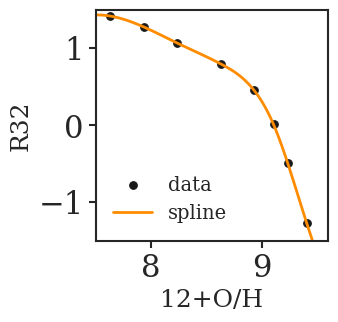

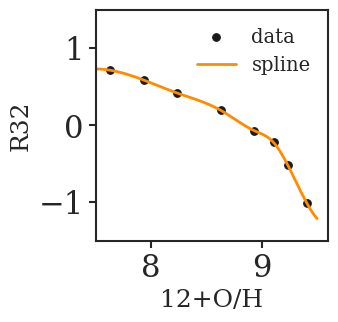

In [1039]:
spl_oh_to_o32_3e8 = oh_to_r23(oh_list, o32_q3e8)
spl_oh_to_o32_8e7 = oh_to_r23(oh_list, o32_q8e7)


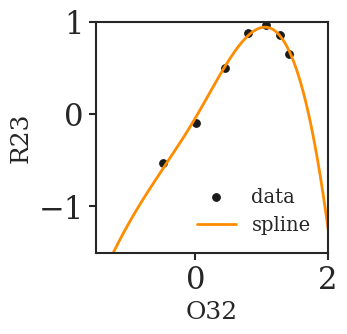

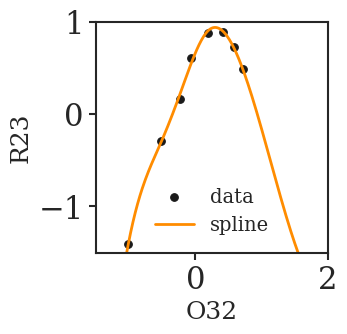

In [1030]:
spl_o32_to_r23_3e8 = x_to_y(o32_q3e8, r32_q3e8, xlab="O32",ylab="R23")
spl_o32_to_r23_8e7 = x_to_y(o32_q8e7, r32_q8e7, xlab="O32",ylab="R23")

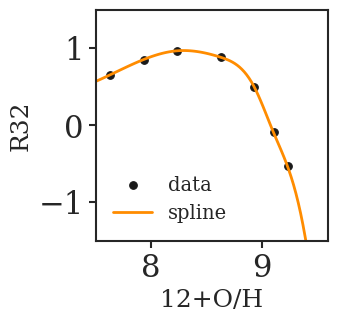

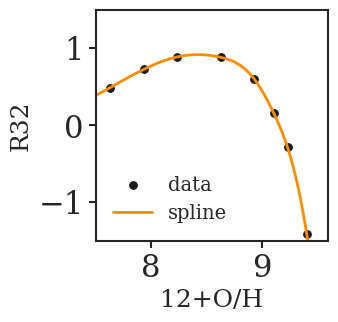

In [1031]:
spl_oh_to_r23_3e8 = oh_to_r23(oh_list, r32_q3e8)
spl_oh_to_r23_8e7 = oh_to_r23(oh_list, r32_q8e7)


In [1010]:
# fig,ax = make_subplots(ncol = 1, nrow = 1, return_fig=True)

# # ax[0].scatter(np.log10(dwarf_r32), np.log10(dwarf_o32),s=1,alpha=0.1,color = "darkcyan")
# # ax[0].scatter(np.log10(all_r32), np.log10(all_o32),s=1,alpha=0.05,color = "grey")

# plot_2d_dist(np.log10(all_r32), np.log10(all_o32), 100, 100, 
#                 cmin=1.e-4, cmax=1.0, smooth=10, clevs=[0,0.68,0.95],ax=ax[0], bounds= np.log10(np.array([ 0.5,20,0.1,100 ])),
#             cmap = make_cmap("k"), color = "grey", filled=True, label = "BGS Bright",cmap_alpha=1)

# plot_2d_dist(np.log10(dwarf_r32), np.log10(dwarf_o32), 250, 250, 
#                 cmin=1.e-4, cmax=1.0, smooth=10, clevs=[0,0.68,0.95,0.997],ax=ax[0], bounds= np.log10(np.array([ 0.5,20,0.1,100 ])),
#             cmap = make_cmap("darkcyan"), color = "k", filled=True, label = "BGS Bright",cmap_alpha=1)


# for axi in ax:
#     axi.set_xlim(np.log10(np.array([0.5,20])))
    
#     axi.set_ylim(np.log10(np.array([0.1,100])))
    
#     major_xticks = np.array([1, 10])
#     major_yticks = np.array([0.1, 1, 10,100])
#     axi.set_xticks(np.log10(major_xticks))
#     axi.set_yticks(np.log10(major_yticks))
#     axi.set_xticklabels(major_xticks, fontsize=14)
#     axi.set_yticklabels(major_yticks, fontsize=14)
    
#     # --- Minor ticks (equally spaced in linear space, then log10) ---
#     minor_xticks = np.log10(np.array([2,3,4,5,6,7,8,9,20]))  # between 1 and 10
#     minor_yticks = np.log10(np.array([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,2,3,4,5,6,7,8,9,20,30,40,50,60,70,80,90]))  # between 0.1-1 and 1-10
#     axi.set_xticks(minor_xticks, minor=True)
#     axi.set_yticks(minor_yticks, minor=True)
    
#     axi.tick_params(which='major', length=8)
#     axi.tick_params(which='minor', length=4)

# ax[0].set_ylabel(r'[OIII]$_{\mathregular{5007}}$ / [OII]$_{\mathregular{3727}}$', fontsize=15)
# ax[0].set_xlabel(r'[OIII]$_{\mathregular{5007}}$ + [OII]$_{\mathregular{3727}}$ / H$\beta$', fontsize=15)
    
# # ax[0].text(0.3,0.75,"DESI DR1\n $z < 0.5$",fontsize = 15,color = "k",transform=ax[0].transAxes, ha='center',  va='bottom')

# ax[0].text(0.05,0.9,r"DESI Dwarfs, $M_{\bigstar} < 10^{9} M_{\odot}$",fontsize = 12,color = "darkcyan",
#            transform=ax[0].transAxes, weight="bold")

# ax[0].text(0.05,0.8,r"DESI, $M_{\bigstar} > 10^{10} M_{\odot}$",fontsize = 12,color = "grey",
#            transform=ax[0].transAxes,weight="bold")

# plt.show()

In [1011]:
from matplotlib.ticker import StrMethodFormatter

/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/scipy/signal/_signaltools.py:1611: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/scipy/signal/_signaltools.py:1611: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)
/global/u1/v/virajvm/DESI2_LOWZ/desi_dwarfs/code/desi_lowz_funcs.py:2029: UserWarning: Log scale: values of z <= 0 have been masked
  cs = ax.contourf(X, Y, H, linewidths=np.array([1.0,0.75, 0.5, 0.25])[::-1], cmap=cmap, levels = sorted(lvls),
/global/u1/v/virajvm/DESI2_LOWZ/desi_dwarfs/code/desi_lowz_funcs.py:2029: UserWarning: linewidths is ignored by contourf
  cs = ax.contourf(X, Y, H, linewidths=np.array([1.0,0.75, 0.5, 0.25])[::-1], cmap=cmap, levels = sorted(lvls),
/global/u1/v/virajvm/DESI2_LOWZ/desi_dwarfs/code/desi_lowz_funcs.py:2029: UserWarning

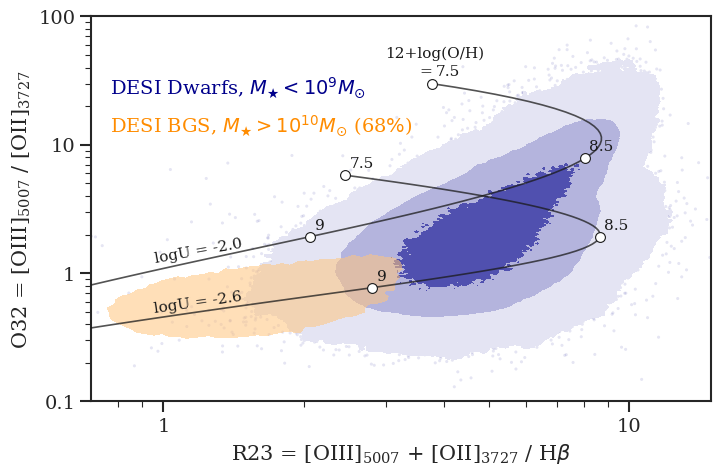

In [1104]:
# fig,ax = make_subplots(ncol = 1, nrow = 1, return_fig=True)
fig,ax = plt.subplots(1,1,figsize = (8,5))
ax = [ax]

ax[0].scatter(np.log10(dwarf_r32), np.log10(dwarf_o32),s=5,alpha=0.1,facecolor = "darkblue",edgecolor="none", rasterized=True)

plot_2d_dist(np.log10(dwarf_r32), np.log10(dwarf_o32), 250, 250, 
                cmin=1.e-4, cmax=1.0, smooth=10, clevs=[0,0.68,0.95,0.997],ax=ax[0], bounds= np.log10(np.array([ 0.4,20,0.1,100 ])),
            cmap = make_cmap("darkblue"), color = "k", filled=True, label = "BGS Bright",cmap_alpha=1)

plot_2d_dist(np.log10(all_r32), np.log10(all_o32), 100, 100, 
                cmin=1.e-4, cmax=1.0, smooth=10, clevs=[0,0.68],ax=ax[0], bounds= np.log10(np.array([ 0.4,20,0.1,100 ])),
            cmap = make_cmap("darkorange"), color = "grey", filled=True, label = "BGS Bright",cmap_alpha=0.55)

# plot_2d_dist(np.log10(all_r32), np.log10(all_o32), 100, 100, 
#                 cmin=1.e-4, cmax=1.0, smooth=10, clevs=[0,0.68,0.95],ax=ax[0], bounds= np.log10(np.array([ 0.4,20,0.1,100 ])),
#             cmap = make_cmap("k"), color = "grey", filled=False, label = "BGS Bright",cmap_alpha=0.5)


for axi in ax:
    axi.set_xlim(np.log10(np.array([0.7,15])))
    
    axi.set_ylim(np.log10(np.array([0.1,100])))
    
    major_xticks = np.array([1, 10])
    major_yticks = np.array([0.1, 1, 10,100])
    axi.set_xticks(np.log10(major_xticks))
    axi.set_yticks(np.log10(major_yticks))
    axi.set_xticklabels(major_xticks, fontsize=14)
    axi.set_yticklabels(major_yticks, fontsize=14)
    axi.set_yticklabels([f"{int(y)}" if y >= 1 else f"{y:g}" for y in major_yticks], fontsize=14)

    # --- Minor ticks (equally spaced in linear space, then log10) ---
    minor_xticks = np.log10(np.array([0.8,0.9,2,3,4,5,6,7,8,9]))  # between 1 and 10
    minor_yticks = np.log10(np.array([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,2,3,4,5,6,7,8,9,20,30,40,50,60,70,80,90]))  # between 0.1-1 and 1-10
    axi.set_xticks(minor_xticks, minor=True)
    axi.set_yticks(minor_yticks, minor=True)
    
    axi.tick_params(which='major', length=8)
    axi.tick_params(which='minor', length=4)

ax[0].set_ylabel(r'O32 = [OIII]$_{\mathregular{5007}}$ / [OII]$_{\mathregular{3727}}$', fontsize=15)
ax[0].set_xlabel(r'R23 = [OIII]$_{\mathregular{5007}}$ + [OII]$_{\mathregular{3727}}$ / H$\beta$', fontsize=15)
    
# ax[0].text(0.3,0.75,"DESI DR1\n $z < 0.5$",fontsize = 15,color = "k",transform=ax[0].transAxes, ha='center',  va='bottom')

ax[0].text(0.03,0.8,r"DESI Dwarfs, $M_{\bigstar} < 10^{9} M_{\odot}$",fontsize = 14,color = "darkblue",
           transform=ax[0].transAxes)

ax[0].text(0.03,0.7,r"DESI BGS, $M_{\bigstar} > 10^{10} M_{\odot}$ (68$\%$)",fontsize = 14,color = "darkorange",
           transform=ax[0].transAxes)

o32_3e8_grid = np.linspace( np.min(o32_q3e8) , np.max(o32_q3e8)+0.06, 100 )

#plot the photo-ionization tracks
ax[0].plot(spl_o32_to_r23_3e8(o32_3e8_grid), o32_3e8_grid, 'k', ls = "-",alpha=0.75, zorder = 10)

for oh in [7.5,8.5,9]:
    x_curve = spl_o32_to_r23_3e8(o32_3e8_grid)
    y_curve = o32_3e8_grid
    
    # Original approximate point
    x_target = spl_oh_to_r23_3e8(oh)
    y_target = spl_oh_to_o32_3e8(oh)

    # Compute Euclidean distance to every point on the curve
    distances = np.sqrt((x_curve - x_target)**2 + (y_curve - y_target)**2)

    # Find the index of the closest curve point
    idx_closest = np.argmin(distances)
    x_closest = x_curve[idx_closest]
    y_closest = y_curve[idx_closest]

    # Plot it
    ax[0].scatter(x_closest, y_closest, facecolor="white", edgecolor="k", s=50, zorder = 20)
    ax[0].text(x_closest + 0.01, y_closest + 0.06, f"{oh}", color = "k", fontsize = 11)

    
#let us draw dots at the specific metallicity points

o32_8e7_grid = np.linspace( np.min(o32_q8e7) , np.max(o32_q8e7)+0.05, 100 )

ax[0].plot(spl_o32_to_r23_8e7(o32_8e7_grid), o32_8e7_grid, 'k', ls = "-",alpha=0.75,zorder=10)

for oh in [7.5,8.5,9]:
    x_curve = spl_o32_to_r23_8e7(o32_8e7_grid)
    y_curve = o32_8e7_grid
    
    # Original approximate point
    x_target = spl_oh_to_r23_8e7(oh)
    y_target = spl_oh_to_o32_8e7(oh)

    # Compute Euclidean distance to every point on the curve
    distances = np.sqrt((x_curve - x_target)**2 + (y_curve - y_target)**2)

    # Find the index of the closest curve point
    idx_closest = np.argmin(distances)
    x_closest = x_curve[idx_closest]
    y_closest = y_curve[idx_closest]

    # Plot it
    ax[0].scatter(x_closest, y_closest, facecolor="white", edgecolor="k", s=50, zorder = 20)
    ax[0].text(x_closest + 0.01, y_closest + 0.06, f"{oh}", color = "k", fontsize = 11)


ax[0].text(0.475,1.68,"12+log(O/H)",fontsize = 11,color = "k")
ax[0].text(0.55,1.54,"=",fontsize = 11,color = "k")

c_cms = 3e5*1e3*1e2

ax[0].text(0.1,0.36,f"logU = {np.log10(3e8/c_cms):.1f}", fontsize = 11,color="k", transform=ax[0].transAxes,rotation=10)

ax[0].text(0.1,0.23,f"logU = {np.log10(8e7/c_cms):.1f}", fontsize = 11,color="k", transform=ax[0].transAxes,rotation=8)

plt.savefig("/global/homes/v/virajvm/DESI2_LOWZ/quenched_fracs_nbs/paper_plots/desi_dwarfs_nebular_diag.pdf",bbox_inches="tight")

plt.show()

30000000000.0

In [1046]:
def get_bgsb_massive_stuff(hpx):
    #opening some random fastspec file that has a lot of 
    fspec_hdu = fits.open(f"/global/cfs/cdirs/desi/public/dr1/vac/dr1/fastspecfit/iron/v3.0/catalogs/fastspec-iron-main-bright-nside1-hp{hpx}.fits")

    print("Done reading file!")
    metadata = fspec_hdu["METADATA"].data
    specphot = fspec_hdu["SPECPHOT"].data
    fastspec_all = fspec_hdu["FASTSPEC"].data

    zmask = (metadata["DELTACHI2"] > 40) & (metadata["SPECTYPE"] == "GALAXY")
    mstar_mask = (specphot["LOGMSTAR"] > 10)
    tot_mask = zmask & mstar_mask

    fastspec_non_dwarf = Table(fastspec_all[tot_mask])

    print("Obtained filtered fastspec table!")

    
    snr_non_dwarf_mask = line_snr_mask(fastspec_non_dwarf, line_names=["HBETA","HALPHA","OIII_5007", "OIII_4959","OII_3726"],snr_val=3)

    all_o32 = compute_o32(fastspec_non_dwarf[snr_non_dwarf_mask])
    all_r32 = compute_r32(fastspec_non_dwarf[snr_non_dwarf_mask])

    return all_r32, all_o32
    


In [1018]:
all_r32_1, all_o32_1 = get_bgsb_massive_stuff("01")
all_r32_2, all_o32_2 = get_bgsb_massive_stuff("06")

#let us stack these
all_r32 = np.concatenate([all_r32_1, all_r32_2])
all_o32 = np.concatenate([all_o32_1, all_o32_2])


Done reading file!
Obtained filtered fastspec table!
Done reading file!
Obtained filtered fastspec table!


In [439]:
# # fspec_all = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_fastspec_catalog/iron_fastspec_v3.fits")
# snr_all_mask = line_snr_mask(fspec_all, line_names=["HBETA","HALPHA","OIII_5007", "OIII_4959","OII_3726"],snr_val=3)
# fspec_all = fspec_all[snr_all_mask]
# # fspec_non_dwarf = fspec_all[~np.isin(fspec_all["TARGETID"], fspec_cat["TARGETID"].data)]
# all_o32 = compute_o32(fspec_non_dwarf)
# all_r32 = compute_r32(fspec_non_dwarf)


Plot 2) Stellar velocity dispersions? How reliable are they etc. connetion with stellar continuum

Plot 3) Gas velocity dispersions? How reliable are they etc.

Plot 4) When is EW measurements reliable? How well does the continuum have to be measured 

Plot 5) DN4000, which one to use, how robust is it etc.

Plot 6) How different the ELG and BGS BRIGHT etc. samples are in color color space

In [567]:
main_clean = main[(main["PHOTOMETRY_UPDATED"] == False) & (main["DWARF_MASKBIT"] == 0) & (main["Z"] < 0.2)]

In [568]:

main_clean["g-r"] =main_clean["MAG_G"] - main_clean["MAG_R"] 
main_clean["r-z"] =main_clean["MAG_R"] - main_clean["MAG_Z"] 


In [583]:
main_elg = main_clean[ main_clean["SAMPLE"] == "ELG" ]
main_bgs = main_clean[ (main_clean["SAMPLE"] == "BGS_BRIGHT") | (main_clean["SAMPLE"] == "BGS_FAINT") ]
main_lowz = main_clean[ main_clean["SAMPLE"] == "LOWZ" ]


/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/scipy/signal/_signaltools.py:1611: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/scipy/signal/_signaltools.py:1611: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)
/global/u1/v/virajvm/DESI2_LOWZ/desi_dwarfs/code/desi_lowz_funcs.py:2029: UserWarning: Log scale: values of z <= 0 have been masked
  cs = ax.contourf(X, Y, H, linewidths=np.array([1.0,0.75, 0.5, 0.25])[::-1], cmap=cmap, levels = sorted(lvls),
/global/u1/v/virajvm/DESI2_LOWZ/desi_dwarfs/code/desi_lowz_funcs.py:2029: UserWarning: linewidths is ignored by contourf
  cs = ax.contourf(X, Y, H, linewidths=np.array([1.0,0.75, 0.5, 0.25])[::-1], cmap=cmap, levels = sorted(lvls),
/global/u1/v/virajvm/DESI2_LOWZ/desi_dwarfs/code/desi_lowz_funcs.py:2032: UserWarning

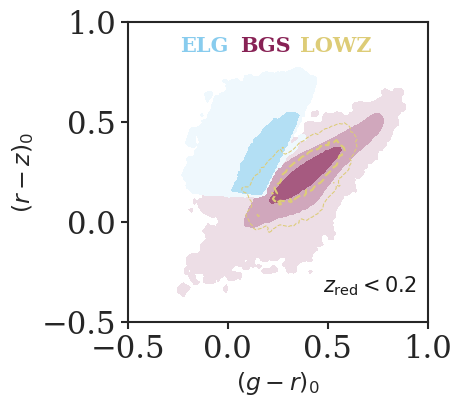

In [873]:
fig,ax = make_subplots(ncol = 1, nrow = 1, return_fig=True)


             
plot_2d_dist(main_bgsb["g-r"], main_bgsb["r-z"], 150, 150, 
                cmin=1.e-4, cmax=1.0, smooth=3, clevs=[0,0.68,0.95,0.997],ax=ax[0], bounds= np.array([ -1,1,-1,1]),
            cmap = make_cmap(sample_colors["BGS_BRIGHT"]), color = "k", filled=True, cmap_alpha=1)

plot_2d_dist(main_elg["g-r"], main_elg["r-z"], 150, 150, 
                cmin=1.e-4, cmax=1.0, smooth=3, clevs=[0,0.68,0.95],ax=ax[0], bounds= np.array([ -1,1,-1,1]),
            cmap = make_cmap(sample_colors["ELG"]), color = sample_colors["ELG"], filled=True, cmap_alpha=1)


plot_2d_dist(main_lowz["g-r"], main_lowz["r-z"], 150, 150, 
                cmin=1.e-4, cmax=1.0, smooth=3, clevs=[0,0.68,0.95],ax=ax[0], bounds= np.array([ -1,1,-1,1]),
            cmap = make_cmap(sample_colors["LOWZ"] ), color = sample_colors["LOWZ"], filled=False, cmap_alpha=1)


start = 0.175
ax[0].text(start,0.9,"ELG",color = sample_colors["ELG"], transform=ax[0].transAxes, weight="bold",fontsize = 15 )
ax[0].text(start+0.2,0.9,"BGS",color = sample_colors["BGS_BRIGHT"], transform=ax[0].transAxes, weight="bold",fontsize = 15 )
ax[0].text(start+0.4,0.9,"LOWZ",color = sample_colors["LOWZ"], transform=ax[0].transAxes, weight="bold",fontsize = 15 )

ax[0].text(0.65,0.1,r"$z_{\rm red} < 0.2$",color = "k", transform=ax[0].transAxes,fontsize = 15 )




ax[0].set_xlim([-0.5,1])
ax[0].set_ylim([-0.5,1])

ax[0].set_xlabel(r"$(g-r)_0$",fontsize=17)
ax[0].set_ylabel(r"$(r-z)_0$",fontsize=17)

ax[0].set_xticks([-0.5,0,0.5,1.0])
ax[0].set_yticks([-0.5,0,0.5,1.0])

plt.savefig("/global/homes/v/virajvm/DESI2_LOWZ/quenched_fracs_nbs/paper_plots/desi_dwarfs_gr_rz_plot.pdf",bbox_inches="tight")

plt.show()

Plot 7) some multi-corner plot showing the different dependencies of dwarf within < 100 Mpc

In [765]:
from fastspec_funcs import get_halpha_sfrs

In [759]:
main_100mpc = main[(main["LUMI_DIST_MPC"] < 200) & (main["DWARF_MASKBIT"] == 0)]
fspec_100mpc = fastspec[(main["LUMI_DIST_MPC"] < 200) & (main["DWARF_MASKBIT"] == 0)]

In [760]:
main_100mpc["g-r"] = main_100mpc["MAG_G"] - main_100mpc["MAG_R"] 

In [761]:
# main_100mpc = main_100mpc[ (fspec_100mpc["HALPHA_EW"] >=  0) ]
# fspec_100mpc = fspec_100mpc[ (fspec_100mpc["HALPHA_EW"] >=  0) ]


In [762]:
halpha_ew_100mpc = np.array(fspec_100mpc["HALPHA_EW"])
gr_100mpc = np.array(main_100mpc["g-r"] )
log_mstar = np.array(main_100mpc["LOG_MSTAR_M24"] )

print(len(halpha_ew_100mpc), len(gr_100mpc), len(log_mstar))

84785 84785 84785


In [767]:
##estimate the SFR using the total magnitude, the aperture correction will not be robust here, but interesting to plot
log_halpha_sfrs = get_halpha_sfrs(main_100mpc, fspec_100mpc["HALPHA_EW"], fspec_100mpc["HALPHA_EW_IVAR"])

In [840]:
r12_arcsec = main_100mpc["SHAPE_PARAMS"].data[:,0]

mur_100mpc = main_100mpc["MAG_R"] + 2.5*np.log10(2*np.pi*r12_arcsec**2)

#update this using the Z_CMB instead of heliocentric redshift
r12_kpc = (Planck18.angular_diameter_distance( main_100mpc["Z"] ).value) * 1000 * r12_arcsec/206265


/tmp/ipykernel_2253195/2460894042.py:3: RuntimeWarning: divide by zero encountered in log10
  mur_100mpc = main_100mpc["MAG_R"] + 2.5*np.log10(2*np.pi*r12_arcsec**2)


In [796]:
# mur[main_100mpc["PHOTOMETRY_UPDATED"]==1]

In [828]:
from astropy.cosmology import Planck18, z_at_value

In [845]:
r12_kpc.max()

12.296802622213738

In [ ]:
import cmasher as cmr

/tmp/ipykernel_2253195/3876957067.py:3: RuntimeWarning: invalid value encountered in log10
  data = [log_mstar, np.log10(halpha_ew_100mpc+1), log_halpha_sfrs,  gr_100mpc, np.log10(r12_kpc), mur_100mpc ]
/tmp/ipykernel_2253195/3876957067.py:3: RuntimeWarning: divide by zero encountered in log10
  data = [log_mstar, np.log10(halpha_ew_100mpc+1), log_halpha_sfrs,  gr_100mpc, np.log10(r12_kpc), mur_100mpc ]


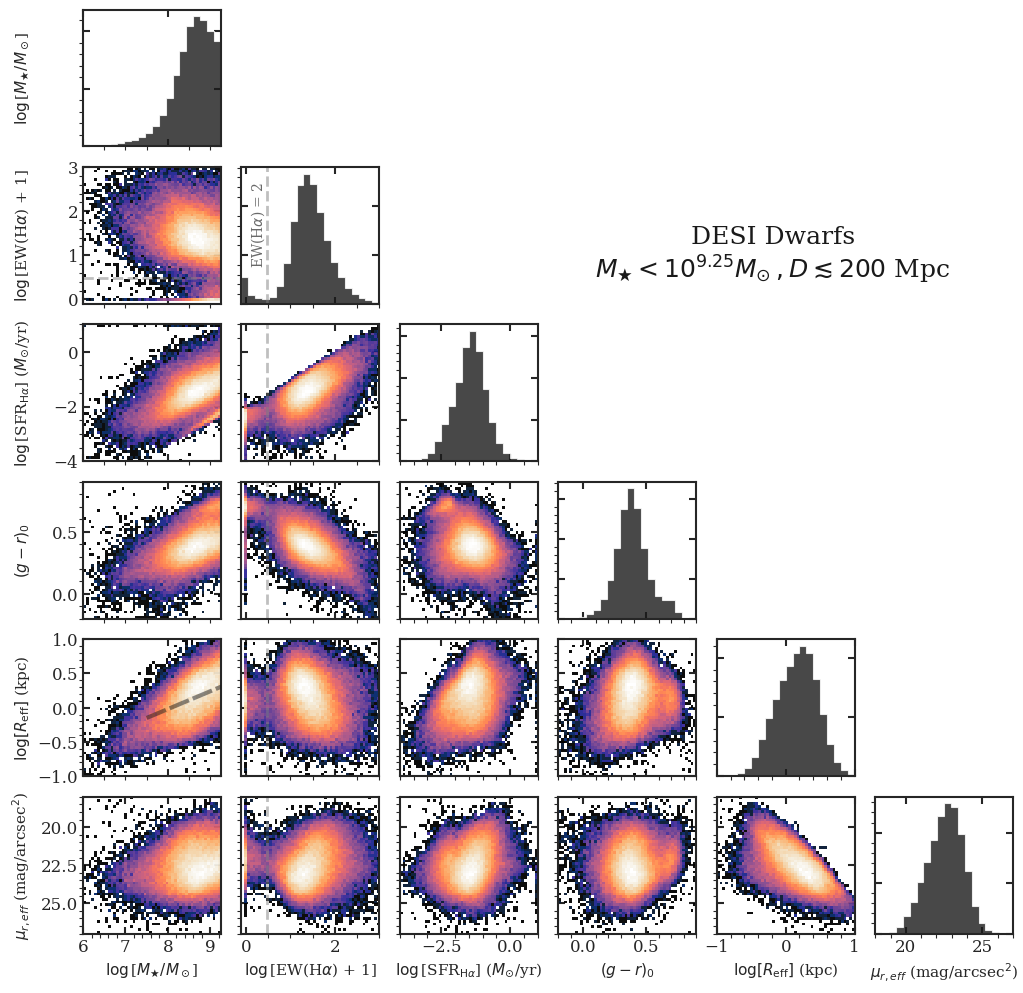

In [872]:

# === Data and labels ===
labels = [r"$\log$[$M_\bigstar / M_\odot$]", r"$\log$[EW(H$\alpha$) + 1]", r"$\log$[SFR$_{\text{H}\alpha}$] ($M_{\odot}$/yr)", r"$(g − r)_0$",r"$\log[R_{\rm eff}]$ (kpc)", r"$\mu_{r, eff}$ (mag/arcsec$^2$)"]
data = [log_mstar, np.log10(halpha_ew_100mpc+1), log_halpha_sfrs,  gr_100mpc, np.log10(r12_kpc), mur_100mpc ]
n = len(data)

# === User-specified limits (set None for auto) ===
limits = [
    (6, 9.25) ,        # for log(M*)
    (-0.1, 3),          # for log Hα EW + 1[Å]
    (-4, 1),          # for log sfr
    (-0.2, 0.9),      # for g−r
    (-1, 1),      # for reff
    (18, 27)       # for mur
]

# === Figure setup ===
fig, axes = plt.subplots(n, n, figsize=(12, 12))
plt.subplots_adjust(wspace=0.15, hspace=0.15)

fsize_label = 11

cmap = cmr.torch

# === Plot ===
for i in range(n):
    for j in range(n):
        ax = axes[i, j]

        if i < j:
            ax.axis("off")
            continue

        if i == j:
            # 1D histogram on the diagonal
            ax.hist(
                data[i],
                bins=20,
                color="k",
                histtype="stepfilled",
                alpha=0.8,
                range=limits[i],
                rasterized=True
            )
            ax.set_xlim(limits[i])
            ax.set_yticklabels([])

        else:
            # 2D histogram (log-normalized for better dynamic range)
            h = ax.hist2d(
                data[j],
                data[i],
                bins=50,
                cmap=cmap,
                norm=LogNorm(),
                alpha=0.95,
                range=[limits[j], limits[i]],
                rasterized=True
            )

            
            ax.set_xlim(limits[j])

            if i == n-1:
                ax.set_ylim(limits[i][::-1])

        # Axis labels
        if i == n - 1:
            ax.set_xlabel(labels[j], fontsize=fsize_label)
        else:
            ax.set_xticklabels([])

        if j == 0:
            ax.set_ylabel(labels[i], fontsize=fsize_label)
        else:
            ax.set_yticklabels([])

        if j == 1:
            #we want to draw a line at EW = 2A, but we need to draw it at 6 as we are adding 1 to everything
            ax.axvline(x = np.log10(3),color = "grey",ls="--",lw=2,alpha=0.5 )      
            if i == j:
                ax.text(0.06,0.3,r"EW(H$\alpha$) = 2",color = "dimgrey",rotation=90,fontsize = 10,transform=ax.transAxes )

        if i == 1 and j == 0:
            ax.axhline(y = np.log10(3),color = "grey",ls="--",lw=2,alpha=0.5 )

        if j == 0 and i == n-1:
            ax.set_xticks([6,7,8,9])

        if j == 0 and i == n - 2:
            #plot the line from the SAGA size-mass paper
            mstar_grid = np.linspace(7.5,9.5)
            log_r12_model = 0.26*mstar_grid - 2.10
            ax.plot(mstar_grid, log_r12_model, color = "k",lw=3,zorder=10,alpha=0.5,ls=(0,(5,1)))
            
        # Tick and spine styling
        ax.tick_params(axis="both", labelsize=12, direction="in", top=True, right=True)
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.minorticks_on()

fig.text(
    0.7, 0.7,                              # x, y position (in figure coordinates)
    "DESI Dwarfs\n" r"$M_{\bigstar} < 10^{9.25} M_{\odot} \,, D \lesssim 200$ Mpc",   # text
    fontsize=18,
    ha="center", va="top", color="k"
)


plt.savefig("/global/homes/v/virajvm/DESI2_LOWZ/quenched_fracs_nbs/paper_plots/desi_dwarfs_corner_plot.pdf",bbox_inches="tight")
fig.align_labels()
plt.show()


In [27]:
from consolidate_photometry import get_fastspec_fit_catalog_V2

In [28]:
get_fastspec_fit_catalog_V2()

Reading 0:250000 out of 17995820
Reading 250000:500000 out of 17995820
Reading 500000:750000 out of 17995820
Reading 750000:1000000 out of 17995820
Reading 1000000:1250000 out of 17995820
Reading 1250000:1500000 out of 17995820
Reading 1500000:1750000 out of 17995820
Reading 1750000:2000000 out of 17995820
Reading 2000000:2250000 out of 17995820
Reading 2250000:2500000 out of 17995820
Reading 2500000:2750000 out of 17995820
Reading 2750000:3000000 out of 17995820
Reading 3000000:3250000 out of 17995820
Reading 3250000:3500000 out of 17995820
Reading 3500000:3750000 out of 17995820
Reading 3750000:4000000 out of 17995820
Reading 4000000:4250000 out of 17995820
Reading 4250000:4500000 out of 17995820
Reading 4500000:4750000 out of 17995820
Reading 4750000:5000000 out of 17995820
Reading 5000000:5250000 out of 17995820
Reading 5250000:5500000 out of 17995820
Reading 5500000:5750000 out of 17995820
Reading 5750000:6000000 out of 17995820
Reading 6000000:6250000 out of 17995820
Reading 6250

In [76]:
fspec = Table.read("/pscratch/sd/v/virajvm/desi_dwarf_catalogs/dr1/v1.0/temp_cats/shreds_FASTSPEC_hdu.fits")
main = Table.read("/pscratch/sd/v/virajvm/desi_dwarf_catalogs/dr1/v1.0/temp_cats/shreds_MAIN_hdu.fits")


In [105]:
import h5py
import numpy as np

file_path = "/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_spectra/spectra_files/data/desi_dr1_dwarf_catalog_spectra.h5"

with h5py.File(file_path, "r") as f:
    # List all datasets in the file
    print("Datasets in file:", list(f.keys()))
    
    # Read each dataset into memory
    targetids = f["TARGETID"][:]     # shape (N_spectra,)
    zreds     = f["Z"][:]            # shape (N_spectra,)
    wave      = f["WAVE"][:]         # shape (N_wave,) -- same for all spectra
    flux      = f["FLUX"][:]         # shape (N_spectra, N_wave)
    flux_ivar = f["FLUX_IVAR"][:]    # shape (N_spectra, N_wave)
    
# Example: access the first spectrum
first_flux = flux[0, :]
first_z    = zreds[0]
first_targetid = targetids[0]

print("First spectrum TARGETID:", first_targetid)
print("First spectrum redshift:", first_z)
print("Flux array shape:", first_flux.shape)


Datasets in file: ['FLUX', 'FLUX_IVAR', 'TARGETID', 'WAVE', 'Z']
First spectrum TARGETID: 39627066986994125
First spectrum redshift: 0.032918606
Flux array shape: (7781,)


In [109]:
targetids[300000]

39628452176859651

(3700.0, 9800.0)

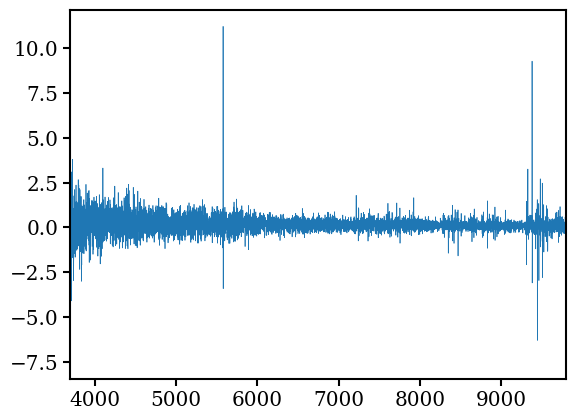

In [107]:
plt.plot(wave, flux[300000],lw=0.5)
plt.xlim([3700,9800])

In [102]:
369000/370

997.2972972972973

In [77]:
temp = Table.read("/pscratch/sd/v/virajvm/desi_dwarf_catalogs/dr1/v1.0/temp_cats/clean_MAIN_hdu.fits")

In [78]:
temp = temp[temp["DWARF_MASKBIT"]==0]

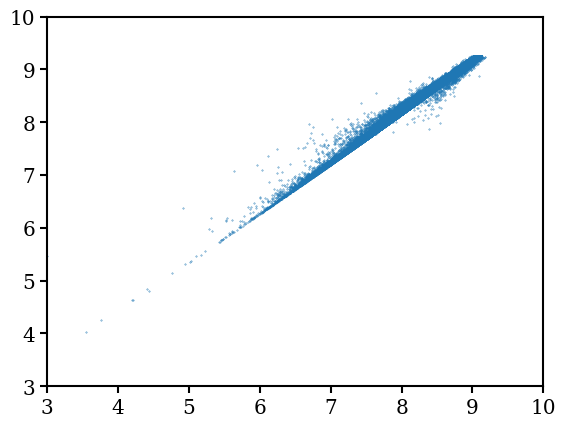

In [79]:
plt.scatter(temp["LOG_MSTAR_SAGA"], temp["LOG_MSTAR_M24"],s=0.1)
plt.xlim([3,10])
plt.ylim([3,10])
plt.show()

In [82]:
filename = "/pscratch/sd/v/virajvm/desi_dwarf_catalogs/dr1/v1.0/desi_dr1_dwarf_catalog.fits"

# Option 1: load the MAIN extension directly as an Astropy Table
main = Table.read(filename, hdu="MAIN")

In [91]:
350000/350

1000.0

In [ ]:
Table.read("/pscratch/sd/v/virajvm/redo_photometry_plots/all_good/north/sweep-160p030-170p035/1697p327/LOWZ_tgid_2275928403083273/source_cat_all_main_segment.fits")



In [172]:
import sys
import os

rootdir = '/global/u1/v/virajvm/'
sys.path.append(os.path.join(rootdir, 'DESI2_LOWZ/desi_dwarfs/code'))


In [163]:
emfit_cat = Table.read("/global/cfs/cdirs/desi/public/dr1/vac/dr1/emfit/v2.3/emfit-dr1-v2.3.fits")

In [164]:
emfit_cat = emfit_cat["TARGETID","Z","HA_N_SIGMA","HA_N_SIGMA_ERR", "HA_N_SIGMA_FLAG", "HA_OUT_SIGMA", "HA_OUT_SIGMA_ERR", "HA_OUT_SIGMA_FLAG", "HA_B_SIGMA", "HA_B_SIGMA_ERR","HA_B_SIGMA_FLAG"]



In [165]:
mask = (emfit_cat["HA_OUT_SIGMA_FLAG"] == 0) | (emfit_cat["HA_N_SIGMA_FLAG"] == 0)  | (emfit_cat["HA_B_SIGMA_FLAG"] == 0) 

In [167]:
emfit_cat_v2 = emfit_cat[mask]

In [169]:
emfit_cat_broad = emfit_cat_v2[emfit_cat_v2["HA_B_SIGMA"] > 0]

In [176]:
main_tgids = main["TARGETID"].data
broad_tgids = emfit_cat_broad["TARGETID"].data

In [177]:
len(main_tgids), len(broad_tgids)

(451538, 180581)

In [181]:
main_broad_det = main[np.isin(main_tgids, broad_tgids)]

In [186]:
emfit_cat_broad[emfit_cat_broad["TARGETID"]==39627334671665216]

TARGETID,Z,HA_N_SIGMA,HA_N_SIGMA_ERR,HA_N_SIGMA_FLAG,HA_OUT_SIGMA,HA_OUT_SIGMA_ERR,HA_OUT_SIGMA_FLAG,HA_B_SIGMA,HA_B_SIGMA_ERR,HA_B_SIGMA_FLAG
,,km / s,km / s,,km / s,km / s,,km / s,km / s,
int64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64
39627334671665216,0.03948277090766776,21.592000969012176,0.6303051558768068,0,0.0,0.0,-1,134.96768488612636,21.47711022488681,0


In [190]:
main_broad_26A = main_broad_det[(main_broad_det["Z"] < 0.01) & (main_broad_det["DEC"] < 10) & ( (main_broad_det["RA"] > 80) | (main_broad_det["RA"] < 40) ) ]  

In [201]:
main_broad_26A

for i in range(len(main_broad_26A)):
    print(f'TGID={main_broad_26A["TARGETID"].data[i]},RA,DEC={main_broad_26A["RA"].data[i]:.4f},{main_broad_26A["DEC"].data[i]:.4f},LogM={main_broad_26A["LOG_MSTAR_SAGA"].data[i]:.1f}, Z={main_broad_26A["Z"].data[i]:.3f}, MASKBIT={main_broad_26A["DWARF_MASKBIT"].data[i]:d} ')
    
    temp = emfit_cat_broad[emfit_cat_broad["TARGETID"] == main_broad_26A["TARGETID"].data[i]]
    print(f'HA_B_SIGMA = {temp["HA_B_SIGMA"].data[0]:.1f} +/- {temp["HA_B_SIGMA_ERR"].data[0]:.1f}')
    print("---")

TGID=39627679858691316,RA,DEC=226.4978,-4.4615,LogM=8.5, Z=0.007, MASKBIT=0 
HA_B_SIGMA = 136.5 +/- 4.8
---
TGID=39627721143225249,RA,DEC=170.1505,-2.7436,LogM=8.2, Z=0.008, MASKBIT=0 
HA_B_SIGMA = 163.6 +/- 16.8
---
TGID=39627742769053897,RA,DEC=19.0052,-1.7664,LogM=6.4, Z=0.006, MASKBIT=0 
HA_B_SIGMA = 170.4 +/- 31.4
---
TGID=39627788411473940,RA,DEC=219.6940,-0.0272,LogM=7.6, Z=0.006, MASKBIT=0 
HA_B_SIGMA = 260.9 +/- 6.6
---
TGID=39627806086268813,RA,DEC=193.1109,0.6951,LogM=7.0, Z=0.010, MASKBIT=0 
HA_B_SIGMA = 567.0 +/- 56.3
---
TGID=39627995329070768,RA,DEC=350.2326,8.3853,LogM=8.1, Z=0.009, MASKBIT=0 
HA_B_SIGMA = 158.9 +/- 2.1
---
TGID=39636701349417815,RA,DEC=348.6967,4.6386,LogM=8.8, Z=0.010, MASKBIT=0 
HA_B_SIGMA = 649.8 +/- 12.8
---
TGID=39627899812187631,RA,DEC=23.1668,4.6415,LogM=8.0, Z=0.007, MASKBIT=0 
HA_B_SIGMA = 191.6 +/- 16.7
---
TGID=39627905885538609,RA,DEC=26.1739,4.8943,LogM=8.1, Z=0.005, MASKBIT=0 
HA_B_SIGMA = 214.9 +/- 8.9
---
TGID=39627595087614545,RA,DEC=1